<a href="https://colab.research.google.com/github/neermesh/deep-learning/blob/master/tensorflow_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')


    
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

In [0]:
from pandas_datareader import data as pdr
df = pdr.get_data_yahoo('CIPLA.NS')  


In [96]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,339.500000,336.000000,338.000000,337.549988,635013.0,319.540070
2010-01-05,342.399994,330.500000,338.549988,331.500000,1664976.0,313.812958
2010-01-06,348.899994,330.350006,332.000000,344.899994,3580916.0,326.497986
2010-01-07,350.399994,340.500000,346.000000,342.049988,1555841.0,323.800049
2010-01-08,346.500000,340.200012,345.000000,341.100006,913410.0,322.900757
...,...,...,...,...,...,...
2020-01-22,480.299988,470.250000,474.500000,471.600006,2380518.0,471.600006
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994
2020-01-27,466.500000,454.200012,457.500000,464.450012,5849003.0,464.450012


In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [0]:
train = train['Adj Close']
test = test['Adj Close']

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train.values.reshape(-1, 1))

In [100]:
train_scaled

array([[0.65370945],
       [0.70106566],
       [0.46613231],
       ...,
       [0.74225337],
       [0.06889443],
       [0.97392232]])

In [103]:
train_scaled.shape

(1984, 1)

In [0]:
X_train = []
y_train = []
for i in range(60,1984):
    X_train.append(train_scaled[i-60:i,0])
    y_train.append(train_scaled[i,0])
X_train,y_train = np.array(X_train), np.array(y_train)

In [106]:
X_train.shape

(1924, 60)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [108]:
X_train.shape

(1924, 60, 1)

In [0]:
from tensorflow.keras import layers

In [0]:


regressor = tf.keras.Sequential()
#regressor.add(layers.Bidirectional(layers.CuDNNLSTM(256, return_sequences=True), 
#                               input_shape=(X_train.shape[1],1)))

regressor.add(layers.LSTM(32, input_shape=(X_train.shape[1],1), return_sequences=True))
regressor.add(layers.Dropout(0.2))




regressor.add(layers.LSTM(4, return_sequences=True))
regressor.add(layers.Dropout(0.2))

regressor.add(layers.Flatten())

regressor.add(layers.Dense(1))
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [111]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 32)            4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 4)             592       
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 4)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 241       
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
____________________________________________________

In [112]:
regressor.fit(X_train,y_train,epochs=30,batch_size=32,validation_split=0.2)

Train on 1539 samples, validate on 385 samples
Epoch 1/30
1539/1539 [==============================] - 7s 4ms/sample - loss: 0.1103 - val_loss: 0.0767
Epoch 2/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0814 - val_loss: 0.0773
Epoch 3/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0795 - val_loss: 0.0763
Epoch 4/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0797 - val_loss: 0.0755
Epoch 5/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0792 - val_loss: 0.0794
Epoch 6/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0791 - val_loss: 0.0764
Epoch 7/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0789 - val_loss: 0.0759
Epoch 8/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0765 - val_loss: 0.0763
Epoch 9/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0769 - val_loss: 0.0789
Epoch 10/30
1539/

In [116]:
#Here

(497,)

In [0]:
dataset_total = pd.concat((train,test),axis=0)
inputs = dataset_total[len(df)- len(test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60,497):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [159]:
predicted_stock_price.shape,X_test.shape

((437, 1), (437, 60, 1))

In [164]:
len([X_test[i][1] for i in range(len(X_test))])
  

437

In [152]:
pd.DataFrame(predicted_stock_price,index=test.index)

ValueError: ignored

In [150]:
pd.concat((pd.DataFrame(test),pd.DataFrame(predicted_stock_price)),axis=1)

ValueError: ignored

ConversionError: ignored

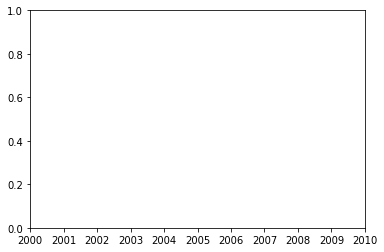

In [137]:


# Visualising the results
plt.plot(test, color = 'red', label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

In [123]:
X_test.shape

(437, 60, 1)

In [86]:
pd.DataFrame({'real':df_test.tolist(),'predicted':predicted_stock_price.tolist()})

ValueError: ignored